In [1]:
import keras
import os
import pywt
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras.layers import *
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Flatten, Dense
from keras.layers.pooling import AveragePooling2D
from keras.layers.pooling import MaxPooling2D
from keras.models import *
from keras.models import Sequential
from skimage import transform
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from tensorflow import keras

In [2]:
def gen_gaussian_noise(signal, SNR):
    """
    :param signal: 原始信号
    :param SNR: 添加噪声的信噪比
    :return: 生成的噪声
    """
    noise = np.random.randn(*signal.shape)  # *signal.shape 获取样本序列的尺寸
    noise = noise - np.mean(noise)
    signal_power = (1 / signal.shape[0]) * np.sum(np.power(signal, 2))
    noise_variance = signal_power / np.power(10, (SNR / 10))
    noise = (np.sqrt(noise_variance) / np.std(noise)) * noise
    signal = signal + noise
    return signal



In [3]:
def get_ECGSegments(x, fs):
    N_col = x.shape[1]
    N_row = x.shape[0]
    N_sample_perStep = 2 * fs  # 30s, step
    N_sample_perWindow = 8 * fs  # 30s, window size
    win_num = N_col - N_sample_perWindow
    s_win = np.arange(0, win_num + N_sample_perStep, N_sample_perStep)
    N_s = len(s_win)

    N_sample_X = N_s * N_sample_perWindow
    X = np.zeros((N_row, N_sample_X))
    for kk in range(0, N_s, 1):
        ind_start = s_win[kk]
        ind_end = ind_start + N_sample_perWindow
        ss = x[:, ind_start:ind_end]

        iind_start = kk * N_sample_perWindow
        iind_end = iind_start + N_sample_perWindow
        X[:, iind_start:iind_end] = np.array(ss)
    X = np.array(X)
    return (X)


In [4]:
def read_specturm(file_dir, N_pixels,list_name):
#     files = os.listdir(file_dir)  # 读入文件夹
    num_imag = len(list_name)  # 统计文件夹中的文件个数
    print(num_imag)  # 打印文件个数
    # 输出所有文件名
    print("所有文件名:")
    out_image = np.ones((num_imag, N_pixels, N_pixels, 3))
    for i in range(num_imag):
#         print(list_name[i])
        s_name = file_dir + list_name[i]
        # image = Image.open(s_name)  # 读取图片文件
        # image=np.array(image)
        # if image.shape[2]==4:
        image=Image.open(s_name).convert('RGB')
        # =============================================================================
        #         plt.imshow(image)
        #         plt.show()            #将图片输出到屏幕
        # =============================================================================
        image_arr0 = np.array(image)  # 将图片以数组的形式读入变量
        image_arr1 = transform.resize(image_arr0, (N_pixels, N_pixels))
        image_arr = np.round(image_arr1*255)
        
        out_image[i, :, :, :] = image_arr.astype('int32')
    return out_image


In [5]:
from tensorflow.keras.layers import Input, concatenate, Dropout, Dense, Flatten, Activation
from tensorflow.keras.layers import MaxPool2D, Conv2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_file

"""
Implementation of Inception Network v4 [Inception Network v4 Paper](http://arxiv.org/pdf/1602.07261v1.pdf) in Keras.
"""

URL = "https://github.com/titu1994/Inception-v4/releases/download/v1.2/inception_v4_weights_tf_dim_ordering_tf_kernels.h5"


def conv_block(x, nb_filter, kernel_size, padding='same', strides=(1, 1), use_bias=False):
    x = Conv2D(nb_filter, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


def inception_stem(input):

    # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)
    x = conv_block(input, 32, (3, 3), strides=(2, 2), padding='valid')
    x = conv_block(x, 32, (3, 3), padding='valid')
    x = conv_block(x, 64, (3, 3))

    x1 = MaxPool2D((3, 3), strides=(2, 2), padding='valid')(x)
    x2 = conv_block(x, 96, (3, 3), strides=(2, 2), padding='valid')

    x = concatenate([x1, x2])

    x1 = conv_block(x, 64, (1, 1))
    x1 = conv_block(x1, 96, (3, 3), padding='valid')

    x2 = conv_block(x, 64, (1, 1))
    x2 = conv_block(x2, 64, (1, 7))
    x2 = conv_block(x2, 64, (7, 1))
    x2 = conv_block(x2, 96, (3, 3), padding='valid')

    x = concatenate([x1, x2])

    x1 = conv_block(x, 192, (3, 3), strides=(2, 2), padding='valid')
    x2 = MaxPool2D((3, 3), strides=(2, 2), padding='valid')(x)

    x = concatenate([x1, x2])
    return x


def inception_A(input):

    a1 = conv_block(input, 96, (1, 1))

    a2 = conv_block(input, 64, (1, 1))
    a2 = conv_block(a2, 96, (3, 3))

    a3 = conv_block(input, 64, (1, 1))
    a3 = conv_block(a3, 96, (3, 3))
    a3 = conv_block(a3, 96, (3, 3))

    a4 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    a4 = conv_block(a4, 96, (1, 1))

    m = concatenate([a1, a2, a3, a4])
    return m


def inception_B(input):
    b1 = conv_block(input, 384, (1, 1))

    b2 = conv_block(input, 192, (1, 1))
    b2 = conv_block(b2, 224, (1, 7))
    b2 = conv_block(b2, 256, (7, 1))

    b3 = conv_block(input, 192, (1, 1))
    b3 = conv_block(b3, 192, (7, 1))
    b3 = conv_block(b3, 224, (1, 7))
    b3 = conv_block(b3, 224, (7, 1))
    b3 = conv_block(b3, 256, (1, 7))

    b4 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    b4 = conv_block(b4, 128, (1, 1))

    m = concatenate([b1, b2, b3, b4])
    return m


def inception_C(input):
    c1 = conv_block(input, 256, (1, 1))

    c2 = conv_block(input, 384, (1, 1))
    c2_1 = conv_block(c2, 256, (1, 3))
    c2_2 = conv_block(c2, 256, (3, 1))
    c2 = concatenate([c2_1, c2_2])

    c3 = conv_block(input, 384, (1, 1))
    c3 = conv_block(c3, 448, (3, 1))
    c3 = conv_block(c3, 512, (1, 3))
    c3_1 = conv_block(c3, 256, (1, 3))
    c3_2 = conv_block(c3, 256, (3, 1))
    c3 = concatenate([c3_1, c3_2])

    c4 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    c4 = conv_block(c4, 256, (1, 1))

    m = concatenate([c1, c2, c3, c4])
    return m


def reduction_A(input):
    r1 = conv_block(input, 384, (3, 3), strides=(2, 2), padding='valid')

    r2 = conv_block(input, 192, (1, 1))
    r2 = conv_block(r2, 224, (3, 3))
    r2 = conv_block(r2, 256, (3, 3), strides=(2, 2), padding='valid')

    r3 = MaxPool2D((3, 3), strides=(2, 2), padding='valid')(input)

    m = concatenate([r1, r2, r3])
    return m


def reduction_B(input):
    if K.image_data_format() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    r1 = conv_block(input, 192, (1, 1))
    r1 = conv_block(r1, 192, (3, 3), strides=(2, 2), padding='valid')

    r2 = conv_block(input, 256, (1, 1))
    r2 = conv_block(r2, 256, (1, 7))
    r2 = conv_block(r2, 320, (7, 1))
    r2 = conv_block(r2, 320, (3, 3), strides=(2, 2), padding='valid')

    r3 = MaxPool2D((3, 3), strides=(2, 2), padding='valid')(input)

    m = concatenate([r1, r2, r3])
    return m


def create_inception_v4(nb_classes=1001, load_weights=True):
    '''
    Creates a inception v4 network

    :param nb_classes: number of classes.txt
    :return: Keras Model with 1 input and 1 output
    '''

    init = Input((299, 299, 3))

    # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th)
    x = inception_stem(init)

    # 4 x Inception A
    for i in range(4):
        x = inception_A(x)

    # Reduction A
    x = reduction_A(x)

    # 7 x Inception B
    for i in range(7):
        x = inception_B(x)

    # Reduction B
    x = reduction_B(x)

    # 3 x Inception C
    for i in range(3):
        x = inception_C(x)

    # Average Pooling
    x = AveragePooling2D((8, 8))(x)

    # Dropout
    x = Dropout(0.2)(x)
    x = Flatten()(x)

    ## Output
    #out = Dense(units=nb_classes, activation='softmax')(x)
    out=Dense(1, activation='relu')(x)
    model = Model(init, out, name='Inception-v4')

    if load_weights:
        weights = get_file('inception_v4_weights_tf_dim_ordering_tf_kernels.h5', URL, cache_subdir='models')

        model.load_weights(weights)
        print("Model weights loaded.")

    return model


# if __name__ == "__main__":
#     inception_v4 = create_inception_v4(load_weights=True)


In [6]:
# from keras.layers import Input, concatenate, Dropout, Dense, Flatten, Activation
# from keras.layers.convolutional import Conv2D 
# from keras.layers.pooling import AveragePooling2D,MaxPooling2D
# from keras.layers.normalization import BatchNormalization
# from keras.models import Model

# from keras import backend as K
# from keras.utils.data_utils import get_file


# """
# Implementation of Inception Network v4 [Inception Network v4 Paper](http://arxiv.org/pdf/1602.07261v1.pdf) in Keras.
# """
# WEIGHTS_PATH = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels.h5'
# WEIGHTS_PATH_NO_TOP = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5'



# def conv_block(x, nb_filter, nb_row, nb_col, padding='same', strides=(1, 1), use_bias=False):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1

#     x = Conv2D(nb_filter, (nb_row, nb_col), strides=strides, padding=padding, use_bias=use_bias)(x)
#     x = BatchNormalization(axis=channel_axis)(x)
#     x = Activation('relu')(x)
#     return x


# def inception_stem(input):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1

#     # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)
#     x = conv_block(input, 32, 3, 3, strides=(2, 2), padding='valid')
#     x = conv_block(x, 32, 3, 3, padding='valid')
#     x = conv_block(x, 64, 3, 3)

#     x1 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
#     x2 = conv_block(x, 96, 3, 3, strides=(2, 2), padding='valid')

#     x=concatenate([x1,x2], channel_axis)

#     x1 = conv_block(x, 64, 1, 1)
#     x1 = conv_block(x1, 96, 3, 3, padding='valid')

#     x2 = conv_block(x, 64, 1, 1)
#     x2 = conv_block(x2, 64, 1, 7)
#     x2 = conv_block(x2, 64, 7, 1)
#     x2 = conv_block(x2, 96, 3, 3, padding='valid')

#     x=concatenate([x1,x2], channel_axis)

#     x1 = conv_block(x, 192, 3, 3, strides=(2, 2), padding='valid')
#     x2 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)

#     x=concatenate([x1,x2], channel_axis)
#     return x


# def inception_A(input):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1

#     a1 = conv_block(input, 96, 1, 1)

#     a2 = conv_block(input, 64, 1, 1)
#     a2 = conv_block(a2, 96, 3, 3)

#     a3 = conv_block(input, 64, 1, 1)
#     a3 = conv_block(a3, 96, 3, 3)
#     a3 = conv_block(a3, 96, 3, 3)

#     a4 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
#     a4 = conv_block(a4, 96, 1, 1)

#     m=concatenate([a1, a2, a3, a4], channel_axis)
#     return m


# def inception_B(input):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1

#     b1 = conv_block(input, 384, 1, 1)

#     b2 = conv_block(input, 192, 1, 1)
#     b2 = conv_block(b2, 224, 1, 7)
#     b2 = conv_block(b2, 256, 7, 1)

#     b3 = conv_block(input, 192, 1, 1)
#     b3 = conv_block(b3, 192, 7, 1)
#     b3 = conv_block(b3, 224, 1, 7)
#     b3 = conv_block(b3, 224, 7, 1)
#     b3 = conv_block(b3, 256, 1, 7)

#     b4 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
#     b4 = conv_block(b4, 128, 1, 1)

#     m=concatenate([b1, b2, b3, b4], channel_axis)
#     return m


# def inception_C(input):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1

#     c1 = conv_block(input, 256, 1, 1)

#     c2 = conv_block(input, 384, 1, 1)
#     c2_1 = conv_block(c2, 256, 1, 3)
#     c2_2 = conv_block(c2, 256, 3, 1)
#     c2=concatenate([c2_1, c2_2], channel_axis)
    
#     c3 = conv_block(input, 384, 1, 1)
#     c3 = conv_block(c3, 448, 3, 1)
#     c3 = conv_block(c3, 512, 1, 3)
#     c3_1 = conv_block(c3, 256, 1, 3)
#     c3_2 = conv_block(c3, 256, 3, 1)
#     c3=concatenate([c3_1, c3_2], channel_axis)
    
#     c4 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
#     c4 = conv_block(c4, 256, 1, 1)

#     m=concatenate([c1, c2, c3, c4], channel_axis)
#     return m


# def reduction_A(input):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1

#     r1 = conv_block(input, 384, 3, 3, strides=(2, 2), padding='valid')

#     r2 = conv_block(input, 192, 1, 1)
#     r2 = conv_block(r2, 224, 3, 3)
#     r2 = conv_block(r2, 256, 3, 3, strides=(2, 2), padding='valid')

#     r3 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(input)

  
#     m=concatenate([r1, r2, r3], channel_axis)
#     return m


# def reduction_B(input):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1

#     r1 = conv_block(input, 192, 1, 1)
#     r1 = conv_block(r1, 192, 3, 3, strides=(2, 2), padding='valid')

#     r2 = conv_block(input, 256, 1, 1)
#     r2 = conv_block(r2, 256, 1, 7)
#     r2 = conv_block(r2, 320, 7, 1)
#     r2 = conv_block(r2, 320, 3, 3, strides=(2, 2), padding='valid')

#     r3 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(input)

#     m=concatenate([r1, r2, r3], channel_axis)
#     return m


# def create_inception_v4(load_weights=True):
#     '''
#     Creates a inception v4 network

#     :param nb_classes: number of classes.txt
#     :return: Keras Model with 1 input and 1 output
#     '''

#     if K.image_data_format() == 'channels_first':
#         init = Input((3, 299, 299))
#     else:
#         init = Input((299, 299, 3))

#     # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th)
#     x = inception_stem(init)

#     # 4 x Inception A
#     for i in range(4):
#         x = inception_A(x)

#     # Reduction A
#     x = reduction_A(x)

#     # 7 x Inception B
#     for i in range(7):
#         x = inception_B(x)

#     # Reduction B
#     x = reduction_B(x)

#     # 3 x Inception C
#     for i in range(3):
#         x = inception_C(x)

#     # Average Pooling
#     x = AveragePooling2D((8, 8))(x)

#     # Dropout
#     x = Dropout(0.2)(x)
#     x = Flatten()(x)

#     # Output
    
    

#     base_model = Model(init, x, name='base_Inception-v4')

#     if load_weights:
#         weights= get_file(
#             'inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5',
#             WEIGHTS_PATH_NO_TOP,
#             cache_subdir='models',
#             md5_hash='9296b46b5971573064d12e4669110969')

#         base_model.load_weights(weights)
#         print("Model weights loaded.")
        
#     x = base_model.output
#     output = Dense(1, activation='relu')(x)
#     model = Model(init, output, name='Inception-v4')

#     return model
    


# # if __name__ == "__main__":
# #     # from keras.utils.visualize_util import plot

# #     inception_v4 = create_inception_v4(load_weights=False)
# #     # inception_v4.summary()

# #     # plot(inception_v4, to_file="Inception-v4.png", show_shapes=True)


In [7]:
# '''
# Copyright 2017 TensorFlow Authors and Kent Sommer

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#    http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# '''
# import numpy as np

# # Sys
# import warnings
# # Keras Core
# from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
# from keras.layers import Input, Dropout, Dense, Flatten, Activation
# from keras.layers.normalization import BatchNormalization
# from keras.layers.merge import concatenate
# from keras import regularizers
# from keras import initializers
# from keras.models import Model
# # Backend
# from keras import backend as K
# # Utils
# from keras.utils.layer_utils import convert_all_kernels_in_model
# from keras.utils.data_utils import get_file


# #########################################################################################
# # Implements the Inception Network v4 (http://arxiv.org/pdf/1602.07261v1.pdf) in Keras. #
# #########################################################################################

# WEIGHTS_PATH = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.0/inception-v4_weights_tf_dim_ordering_tf_kernels.h5'
# WEIGHTS_PATH_NO_TOP = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.0/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5'


# def preprocess_input(x):
#     x = np.divide(x, 255.0)
#     x = np.subtract(x, 0.5)
#     x = np.multiply(x, 2.0)
#     return x


# def conv2d_bn(x, nb_filter, num_row, num_col,
#               padding='same', strides=(1, 1), use_bias=False):
#     """
#     Utility function to apply conv + BN. 
#     (Slightly modified from https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py)
#     """
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1
#     x = Convolution2D(nb_filter, (num_row, num_col),
#                       strides=strides,
#                       padding=padding,
#                       use_bias=use_bias,
#                       kernel_regularizer=regularizers.l2(0.00004),
#                       kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
#     x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
#     x = Activation('relu')(x)
#     return x


# def block_inception_a(input):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1

#     branch_0 = conv2d_bn(input, 96, 1, 1)

#     branch_1 = conv2d_bn(input, 64, 1, 1)
#     branch_1 = conv2d_bn(branch_1, 96, 3, 3)

#     branch_2 = conv2d_bn(input, 64, 1, 1)
#     branch_2 = conv2d_bn(branch_2, 96, 3, 3)
#     branch_2 = conv2d_bn(branch_2, 96, 3, 3)

#     branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
#     branch_3 = conv2d_bn(branch_3, 96, 1, 1)

#     x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
#     return x


# def block_reduction_a(input):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1

#     branch_0 = conv2d_bn(input, 384, 3, 3, strides=(2,2), padding='valid')

#     branch_1 = conv2d_bn(input, 192, 1, 1)
#     branch_1 = conv2d_bn(branch_1, 224, 3, 3)
#     branch_1 = conv2d_bn(branch_1, 256, 3, 3, strides=(2,2), padding='valid')

#     branch_2 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(input)

#     x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
#     return x


# def block_inception_b(input):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1

#     branch_0 = conv2d_bn(input, 384, 1, 1)

#     branch_1 = conv2d_bn(input, 192, 1, 1)
#     branch_1 = conv2d_bn(branch_1, 224, 1, 7)
#     branch_1 = conv2d_bn(branch_1, 256, 7, 1)

#     branch_2 = conv2d_bn(input, 192, 1, 1)
#     branch_2 = conv2d_bn(branch_2, 192, 7, 1)
#     branch_2 = conv2d_bn(branch_2, 224, 1, 7)
#     branch_2 = conv2d_bn(branch_2, 224, 7, 1)
#     branch_2 = conv2d_bn(branch_2, 256, 1, 7)

#     branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
#     branch_3 = conv2d_bn(branch_3, 128, 1, 1)

#     x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
#     return x


# def block_reduction_b(input):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1

#     branch_0 = conv2d_bn(input, 192, 1, 1)
#     branch_0 = conv2d_bn(branch_0, 192, 3, 3, strides=(2, 2), padding='valid')

#     branch_1 = conv2d_bn(input, 256, 1, 1)
#     branch_1 = conv2d_bn(branch_1, 256, 1, 7)
#     branch_1 = conv2d_bn(branch_1, 320, 7, 1)
#     branch_1 = conv2d_bn(branch_1, 320, 3, 3, strides=(2,2), padding='valid')

#     branch_2 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(input)

#     x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
#     return x


# def block_inception_c(input):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1

#     branch_0 = conv2d_bn(input, 256, 1, 1)

#     branch_1 = conv2d_bn(input, 384, 1, 1)
#     branch_10 = conv2d_bn(branch_1, 256, 1, 3)
#     branch_11 = conv2d_bn(branch_1, 256, 3, 1)
#     branch_1 = concatenate([branch_10, branch_11], axis=channel_axis)


#     branch_2 = conv2d_bn(input, 384, 1, 1)
#     branch_2 = conv2d_bn(branch_2, 448, 3, 1)
#     branch_2 = conv2d_bn(branch_2, 512, 1, 3)
#     branch_20 = conv2d_bn(branch_2, 256, 1, 3)
#     branch_21 = conv2d_bn(branch_2, 256, 3, 1)
#     branch_2 = concatenate([branch_20, branch_21], axis=channel_axis)

#     branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
#     branch_3 = conv2d_bn(branch_3, 256, 1, 1)

#     x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
#     return x


# def inception_v4_base(input):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1

#     # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)
#     net = conv2d_bn(input, 32, 3, 3, strides=(2,2), padding='valid')
#     net = conv2d_bn(net, 32, 3, 3, padding='valid')
#     net = conv2d_bn(net, 64, 3, 3)

#     branch_0 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

#     branch_1 = conv2d_bn(net, 96, 3, 3, strides=(2,2), padding='valid')

#     net = concatenate([branch_0, branch_1], axis=channel_axis)

#     branch_0 = conv2d_bn(net, 64, 1, 1)
#     branch_0 = conv2d_bn(branch_0, 96, 3, 3, padding='valid')

#     branch_1 = conv2d_bn(net, 64, 1, 1)
#     branch_1 = conv2d_bn(branch_1, 64, 1, 7)
#     branch_1 = conv2d_bn(branch_1, 64, 7, 1)
#     branch_1 = conv2d_bn(branch_1, 96, 3, 3, padding='valid')

#     net = concatenate([branch_0, branch_1], axis=channel_axis)

#     branch_0 = conv2d_bn(net, 192, 3, 3, strides=(2,2), padding='valid')
#     branch_1 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

#     net = concatenate([branch_0, branch_1], axis=channel_axis)

#     # 35 x 35 x 384
#     # 4 x Inception-A blocks
#     for idx in range(4):
#     	net = block_inception_a(net)

#     # 35 x 35 x 384
#     # Reduction-A block
#     net = block_reduction_a(net)

#     # 17 x 17 x 1024
#     # 7 x Inception-B blocks
#     for idx in range(7):
#     	net = block_inception_b(net)

#     # 17 x 17 x 1024
#     # Reduction-B block
#     net = block_reduction_b(net)

#     # 8 x 8 x 1536
#     # 3 x Inception-C blocks
#     for idx in range(3):
#     	net = block_inception_c(net)

#     return net


# def inception_v4(dropout_keep_prob, weights, include_top):
#     '''
#     Creates the inception v4 network

#     Args:
#     	num_classes: number of classes
#     	dropout_keep_prob: float, the fraction to keep before final layer.
    
#     Returns: 
#     	logits: the logits outputs of the model.
#     '''

#     # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th)
#     if K.image_data_format() == 'channels_first':
#         inputs = Input((3, 299, 299))
#     else:
#         inputs = Input((299, 299, 3))

#     # Make inception base
#     x = inception_v4_base(inputs)


#     # Final pooling and prediction
#     if include_top:
#         # 1 x 1 x 1536
#         x = AveragePooling2D((8,8), padding='valid')(x)
#         x = Dropout(dropout_keep_prob)(x)
#         x = Flatten()(x)
#         # 1536
#         x = Dense(units=1001, activation='softmax')(x)

#     model = Model(inputs, x, name='inception_v4')

#     # load weights
#     if weights == 'imagenet':
#         if K.image_data_format() == 'channels_first':
#             if K.backend() == 'tensorflow':
#                 warnings.warn('You are using the TensorFlow backend, yet you '
#                               'are using the Theano '
#                               'image data format convention '
#                               '(`image_data_format="channels_first"`). '
#                               'For best performance, set '
#                               '`image_data_format="channels_last"` in '
#                               'your Keras config '
#                               'at ~/.keras/keras.json.')
#         if include_top:
#             weights_path = get_file(
#                 'inception-v4_weights_tf_dim_ordering_tf_kernels.h5',
#                 WEIGHTS_PATH,
#                 cache_subdir='models',
#                 md5_hash='9fe79d77f793fe874470d84ca6ba4a3b')
#         else:
#             weights_path = get_file(
#                 'inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5',
#                 WEIGHTS_PATH_NO_TOP,
#                 cache_subdir='models',
#                 md5_hash='9296b46b5971573064d12e4669110969')
#         model.load_weights(weights_path, by_name=True)
        
#     if ~include_top:
#         x = model.output
#         x = AveragePooling2D((8,8), padding='valid')(x)
#         x = Dropout(dropout_keep_prob)(x)
#         x = Flatten()(x)
#         # 1536
#         x = Dense(units=1, activation='relu')(x)
#         model = Model(inputs, x, name='inception_v4')
#     return model


# def create_model(dropout_prob=0.2, weights='imagenet', include_top=False):
#     return inception_v4(dropout_prob, weights, include_top)


In [8]:
fs = 61
flag_GaussianNoise = 0
T = 30

In [9]:
df_ippg = pd.read_excel(
    '30s_ippg_0427.xlsx')  # 8s_ippg_good.xlsx;8s_ippg_good.xlsx;good_30s.xlsx,8s_ippg_update_v.xlsx
x = df_ippg.iloc[:, 3:].values
y = df_ippg.loc[:, 'ECG'].values

In [10]:
df_ippg_more=pd.read_excel(
    '30s_ippg_0512_ss1.xlsx')  
x_more = df_ippg_more.iloc[:, 3:].values
y_more = df_ippg_more.loc[:, 'ECG'].values

In [11]:
print(x_more.shape[0])

808


In [11]:
sc = MinMaxScaler(feature_range=(-1, 1))
x = np.transpose(sc.fit_transform(np.transpose(x)))  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
x = x.astype('float64')

#x, y = shuffle(x, y, random_state=1337)
Nx_row = x.shape[0]  # 返回行,样本个数
Nx_col = x.shape[1]  # 返回列

In [13]:
if flag_GaussianNoise == 1:
    xx = np.array([gen_gaussian_noise(x[i, :], -2) for i in range(Nx_row)])
else:
    xx = x


In [14]:
# print(xx)

In [15]:
# scaler_y = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(y.reshape(-1, 1))
# y = scaler_y.transform(y.reshape(-1, 1))
# y = y.astype('float')
# y = y.reshape(-1, )

FileNotFoundError: [Errno 2] No such file or directory: './spectrum/Part_10_S_Trial10.jpg'

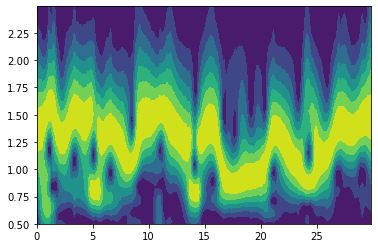

In [14]:
# s_dir_output_specturm = './spectrum_30s_stft_w15s_1/'
s_dir_output_specturm = './spectrum/'
s_dir_output_specturm_more = './addition_spectrum_30s_stft_w15s_1/'
N_pixels = 299
flag_create_spectrum = 0
if flag_create_spectrum == 1:
    fs_bandwidth_plot = [0.5, 2.5]  # plot,0.3Hz-2.5Hz
    fs_bw = fs_bandwidth_plot[1] - fs_bandwidth_plot[0]
    t = np.arange(0, T, 1.0 / fs)  # time

    # wavelet
    wavename = 'cgau8'
    totalscal = 1024 * 4
    fs_resolution = fs / (totalscal * 2)  # freqency resolution
    ind_fs_h = np.ceil(fs_bandwidth_plot[1] / fs_resolution)
    ind_fs_l = np.ceil(fs_bandwidth_plot[0] / fs_resolution)
    ind_fs = np.arange(ind_fs_l, ind_fs_h, 1, "int")  # index
    N_ind_fs = len(ind_fs)
    fc = pywt.central_frequency(wavename)
    cparam = 2 * fc * totalscal
    scales = cparam / np.arange(totalscal, 1, -1)

    x_2d = np.ones((Nx_row, N_ind_fs, Nx_col))  # sample size, frequency,fs*8
    scalar = MinMaxScaler(feature_range=(0, 1))  # 加载函数

    t_downsampling = np.arange(0, T, T / N_pixels)
    x_2d_downsampling = np.ones((Nx_row, N_pixels, N_pixels))
    flag_scalar = 1
    frequencies_downsampling = np.arange(fs_bandwidth_plot[0], fs_bandwidth_plot[1], fs_bw / N_pixels)
    for i in range(Nx_row):
        data = xx[i, :]
        [cwtmatr, frequencies] = pywt.cwt(data, scales, wavename, 1.0 / fs)
        temp = abs(cwtmatr[-ind_fs, :])
        if flag_scalar == 1:
            temp_1 = scalar.fit_transform(temp)  # 归一化,按时间，行
        else:
            temp_1 = temp

        x_2d[i, :, :] = temp_1
        # temp_2                   = cv2.resize(temp_1,(N_pixels,N_pixels),interpolation=cv2.INTER_CUBIC)
        temp_2 = transform.resize(temp_1, (N_pixels, N_pixels))
        x_2d_downsampling[i, :, :] = temp_2

        # ==========================================
        if i == 128:
            plt.figure(figsize=(8, 6))
            plt.subplot(221);
            plt.plot(t, data)
            plt.xlabel(u"t(second)");
            plt.title(u"wavelet sepctrum, 8s", fontsize=10)
            plt.subplot(222)
            plt.contourf(t, frequencies[-ind_fs], temp)
            plt.xlabel(u"t(second)");
            plt.ylabel(u"f(Hz)")
            plt.subplot(223)
            plt.contourf(t, frequencies[-ind_fs], temp_1)
            plt.xlabel(u"t(second), normalized");
            plt.ylabel(u"f(Hz)")
            plt.subplot(224)
            plt.contourf(t_downsampling, frequencies_downsampling, temp_2)  # imgplot = plt.imshow(temp_2)
            plt.xlabel(u"t(second), normalized, downsampling");
            plt.ylabel(u"f(Hz)")
            plt.subplots_adjust(hspace=0.4)
            plt.show()
        # ===========================================
        plt.contourf(t_downsampling, frequencies_downsampling, temp_2)

        ss = s_dir_output_specturm + df_ippg.iloc[i, 0].replace("_emotion_data.avi", ".jpg")
        plt.savefig(ss)
else:
    s_list_original = [df_ippg.iloc[i, 0].replace("_emotion_data.avi", ".jpg") for i in range(x.shape[0])]
#     s_list_original_more = [df_ippg_more.iloc[i, 0] for i in range(x_more.shape[0])]
#     xx_more=read_specturm(s_dir_output_specturm_more, N_pixels, s_list_original_more)
    xx = read_specturm(s_dir_output_specturm, N_pixels, s_list_original)
    
#     plt.imshow(xx[0, :, :, :])
#     plt.axis('off')
#     plt.show()  # 将图片输出到屏幕
#     s_list_file = [s_list_file[i].replace(".jpg", "") for i in range(x.shape[0])]
#     if s_list_file == s_list_original:
#         yy = y
#     else:
#         print("error!!!!!!!!!!!!!!!!!!!!")



In [48]:
print(xx_more[1, 140, 140, 1])

109.0


In [11]:
#from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_resnet_v2 import preprocess_input
# from keras.applications.resnet50 import preprocess_input
xx = preprocess_input(xx)

In [ ]:
xx_more = preprocess_input(xx_more)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


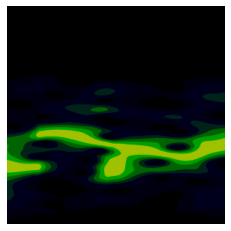

In [51]:
plt.imshow(xx_more[0, :, :, :])
plt.axis('off')
plt.show()  # 将图片输出到屏幕

In [12]:
xx=np.where(xx > 0,xx, 0)
# xx_more=np.where(xx_more > 0,xx_more, 0)

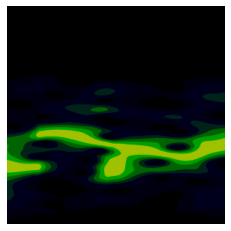

In [79]:
plt.imshow(xx_more[0, :, :, :])
plt.axis('off')
plt.show()  # 将图片输出到屏幕

In [80]:
# scaler_y = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(y.reshape(-1, 1))
# y = scaler_y.transform(y.reshape(-1, 1))
# y = y.astype('float')
# y = y.reshape(-1, )

In [13]:
x_train, x_test, y_train, y_test = train_test_split(xx, y, test_size=0.1, random_state=2)
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

In [14]:
x_train_more, y_train_more = np.array(xx_more), np.array(y_more)
print(x_train_more.shape)

NameError: name 'xx_more' is not defined

In [83]:
x_train=np.vstack((x_train,x_train_more))
y_train=np.append(y_train,y_train_more)

In [20]:
print(x_train.shape)
print(np.isnan(x_test).any())
print(y_train.shape)
print(np.isnan(y_test).any())

(466, 299, 299, 3)
False
(466,)
False


In [14]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense
from keras import backend as K

# create the base pre-trained model
#base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(299, 299, 3))

# base_model = ResNet50(weights='imagenet', include_top=False,input_shape=(299, 299, 3))

base_model = InceptionResNetV2(weights='imagenet', include_top=False,input_shape=(299, 299, 3))

# add a global spatial average pooling layer
x = base_model.output
# let's add a fully-connected layer


# and a linear output layer
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(1024, activation=keras.layers.LeakyReLU(alpha=0.3))(x)#keras.layers.LeakyReLU(alpha=0.3)
# and a logistic layer -- let's say we have 200 classes
prediction = Dense(1, activation=keras.layers.LeakyReLU(alpha=0.3))(x)


# this is the model we will train
model = Model(inputs=base_model.input, outputs=prediction)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non trainable)

In [15]:
#model = create_model(dropout_prob=0.2, weights=None, include_top=False)
#model = create_inception_v4(load_weights=False)

In [16]:
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, decay=0.2, epsilon=1e-08),                 
#                   loss='mse',metrics=['mae'])
# model.compile(
#         optimizer=tf.keras.optimizers.Nadam(lr=0.1, beta_1=0.9, beta_2=0.999, schedule_decay=0.4, epsilon=1e-08),
#         # ,kappa=1-1e-8
#         loss=tf.keras.losses.Huber(delta=0.2, reduction="auto", name="huber_loss"),
#         metrics=['mse', 'mae'])  # with bathnomolization
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=0.05, beta_1=0.9, beta_2=0.999, schedule_decay=0.4, epsilon=1e-08),       #,kappa=1-1e-8
                      loss='mse',metrics=['mae'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 17, 17, 192)  576         conv2d_84[0][0]                  
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, 17, 17, 192)  576         conv2d_87[0][0]                  
__________________________________________________________________________________________________
activation_84 (Activation)      (None, 17, 17, 192)  0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
activation_87 (Activation)      (None, 17, 17, 192)  0           batch_normalization_87[0][0]     
__________________________________________________________________________________________________
block17_3_mixed (Concatenate)   (None, 17, 17, 384)  0           activation_84[0][0]              
          

batch_normalization_173 (BatchN (None, 8, 8, 224)    672         conv2d_173[0][0]                 
__________________________________________________________________________________________________
activation_173 (Activation)     (None, 8, 8, 224)    0           batch_normalization_173[0][0]    
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 8, 8, 192)    399360      block8_2_ac[0][0]                
__________________________________________________________________________________________________
conv2d_174 (Conv2D)             (None, 8, 8, 256)    172032      activation_173[0][0]             
__________________________________________________________________________________________________
batch_normalization_171 (BatchN (None, 8, 8, 192)    576         conv2d_171[0][0]                 
__________________________________________________________________________________________________
batch_norm

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 patience=3,
                                                 verbose=1,
                                                 factor=0.9,
                                                 min_lr=0.00001)
history = model.fit(x_train, y_train,
                       batch_size=16, epochs=20, validation_data=(x_test, y_test),
                       validation_freq=1, callbacks=[reduce_lr], shuffle=True)  #


Epoch 1/20
30/30 [==============================] - 113s 4s/step - loss: 95.3189 - mae: 7.8789 - val_loss: 220.9717 - val_mae: 12.8267
Epoch 2/20
30/30 [==============================] - 75s 2s/step - loss: 100.6232 - mae: 8.1920 - val_loss: 152.5745 - val_mae: 9.8656
Epoch 3/20
30/30 [==============================] - 64s 2s/step - loss: 94.8826 - mae: 7.8926 - val_loss: 223.3632 - val_mae: 11.4852
Epoch 4/20
30/30 [==============================] - 64s 2s/step - loss: 105.7394 - mae: 8.2796 - val_loss: 155.5442 - val_mae: 10.3880
Epoch 5/20
30/30 [==============================] - 64s 2s/step - loss: 95.3229 - mae: 7.8633 - val_loss: 146.8683 - val_mae: 9.9159
Epoch 6/20
30/30 [==============================] - 64s 2s/step - loss: 90.4205 - mae: 7.7557 - val_loss: 290.6841 - val_mae: 14.7793
Epoch 7/20
30/30 [==============================] - 69s 2s/step - loss: 95.2830 - mae: 7.8889 - val_loss: 148.5395 - val_mae: 9.9308
Epoch 8/20
30/30 [==============================] - 76s 3s/ste

In [20]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)


0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed_5b
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 conv2d_12
51 conv2d_14
52 conv2d_17
53 batch_normalization_12
54 batch_normalization_14
55 batch_normalization_17
56 activa

599 conv2d_158
600 conv2d_161
601 batch_normalization_156
602 batch_normalization_158
603 batch_normalization_161
604 activation_156
605 activation_158
606 activation_161
607 conv2d_157
608 conv2d_159
609 conv2d_162
610 batch_normalization_157
611 batch_normalization_159
612 batch_normalization_162
613 activation_157
614 activation_159
615 activation_162
616 max_pooling2d_3
617 mixed_7a
618 conv2d_164
619 batch_normalization_164
620 activation_164
621 conv2d_165
622 batch_normalization_165
623 activation_165
624 conv2d_163
625 conv2d_166
626 batch_normalization_163
627 batch_normalization_166
628 activation_163
629 activation_166
630 block8_1_mixed
631 block8_1_conv
632 block8_1
633 block8_1_ac
634 conv2d_168
635 batch_normalization_168
636 activation_168
637 conv2d_169
638 batch_normalization_169
639 activation_169
640 conv2d_167
641 conv2d_170
642 batch_normalization_167
643 batch_normalization_170
644 activation_167
645 activation_170
646 block8_2_mixed
647 block8_2_conv
648 block8_

In [21]:
for layer in model.layers[:727]:
    layer.trainable = False
for layer in model.layers[727:]:
    layer.trainable = True

In [22]:
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=0.008, beta_1=0.9, beta_2=0.999, schedule_decay=0.4, epsilon=1e-08),       #,kappa=1-1e-8
                      loss='mse',metrics=['mae'])
history = model.fit(x_train, y_train,
                       batch_size=16, epochs=30, validation_data=(x_test, y_test),
                       validation_freq=1, callbacks=[reduce_lr], shuffle=True)  #


Epoch 1/30
30/30 [==============================] - 140s 4s/step - loss: 1392.7619 - mae: 23.9844 - val_loss: 6069466624.0000 - val_mae: 77310.3984
Epoch 2/30
30/30 [==============================] - 88s 3s/step - loss: 148.7016 - mae: 9.9952 - val_loss: 17405.1602 - val_mae: 125.4943
Epoch 3/30
30/30 [==============================] - 89s 3s/step - loss: 132.2206 - mae: 9.3991 - val_loss: 4067.7456 - val_mae: 61.3967
Epoch 4/30
30/30 [==============================] - 89s 3s/step - loss: 153.1623 - mae: 9.8748 - val_loss: 6358.9995 - val_mae: 77.8971
Epoch 5/30
30/30 [==============================] - 93s 3s/step - loss: 129.3461 - mae: 9.2593 - val_loss: 1184.3116 - val_mae: 31.4308
Epoch 6/30
30/30 [==============================] - 88s 3s/step - loss: 141.1561 - mae: 9.6959 - val_loss: 596.6729 - val_mae: 21.4516
Epoch 7/30
30/30 [==============================] - 89s 3s/step - loss: 125.7803 - mae: 9.0259 - val_loss: 1135.3370 - val_mae: 31.1250
Epoch 8/30
30/30 [=================

In [23]:
yy_train = model.predict(x_train)
yy_pred = model.predict(x_test)

# y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
# y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# yy_pred = scaler_y.inverse_transform(yy_pred.reshape(-1, 1))
# yy_train = scaler_y.inverse_transform(yy_train.reshape(-1, 1))



In [24]:
print(y_train)
print(yy_pred)

[ 91.59819772  94.15778252  68.08327737 103.37292162  66.96457766
  64.20711974  58.82725832  74.9065294   91.34399366  95.57148654
  60.46450597  86.69802446  98.40896957  91.87601958  69.04781365
  70.52532073  45.46448087  60.12958963  74.84788621  63.32757016
  96.51336898  76.82021585  88.13450761  95.98723574  58.35549525
  79.89330488  66.09116579  66.75842086  85.06821559  58.85057471
  94.96774194  85.19480519  66.08604954  97.82141436  53.41894061
  81.31396769  80.04275788  52.88135593  83.13663366  81.57195964
  62.52374491  60.10524895  67.16589232  65.6936648   66.14452967
  79.63839404  83.37878988  76.60331581  76.32554392  62.01884253
  77.47279002  69.29936306  76.12108224  66.5385136   69.93036958
  87.74810682  67.69230769 100.76095513  67.09254709  81.49621966
  56.73878628  69.04283448  85.58847513  94.75124045  63.19253977
  59.42369264  65.49656121  75.48412804  81.99653009  93.19131724
  77.54483858  71.69686985  93.37386018  93.05331179  90.76822062
  74.26269

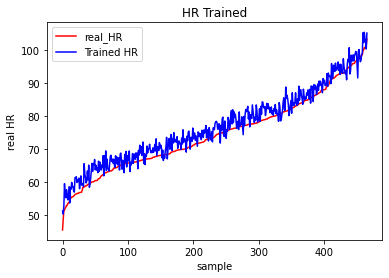

In [25]:

ind_plot_train = np.argsort(y_train)
# error_plot = yy_pred[ind_plot]-y_test[ind_plot]
plt.plot(y_train[ind_plot_train], color='red', label='real_HR')
plt.plot(yy_train[ind_plot_train], color='blue', label='Trained HR')
# plt.plot(error_plot, color='black', label='error')
plt.title('HR Trained')
plt.xlabel('sample')
plt.ylabel('real HR')
plt.legend()
plt.show()



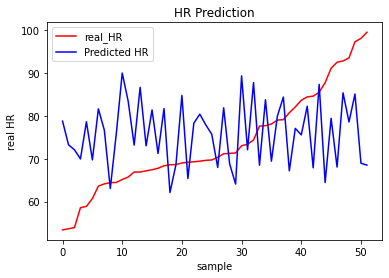

In [26]:
ind_plot_test = np.argsort(y_test)
# error_plot = yy_pred[ind_plot]-y_test[ind_plot]
plt.plot(y_test[ind_plot_test], color='red', label='real_HR')
plt.plot(yy_pred[ind_plot_test], color='blue', label='Predicted HR')
# plt.plot(error_plot, color='black', label='error')
plt.title('HR Prediction')
plt.xlabel('sample')
plt.ylabel('real HR')
plt.legend()
plt.show()



In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(yy_pred, y_test)
mse_t = mean_squared_error(yy_train, y_train)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(yy_pred, y_test))
rmse_t = math.sqrt(mean_squared_error(yy_train, y_train))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(yy_pred, y_test)
mae_t = mean_absolute_error(yy_train, y_train)
print('test set')
print('mse:     %.6f' % mse)
print('rmse:   %.6f' % rmse)
print('mae: %.6f' % mae)
print('train set')
print('mse:     %.6f' % mse_t)
print('rmse:   %.6f' % rmse_t)
print('mae: %.6f' % mae_t)




test set
mse:     189.865129
rmse:   13.779156
mae: 11.480292
train set
mse:     8.490987
rmse:   2.913930
mae: 2.455425
